In [139]:
# libs
import pandas as pd
import numpy as np
from datetime import datetime
import os

# bar plots
import matplotlib.pyplot as plt
import seaborn as sns

In [150]:
# today's date string for file namine automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
print(today_date_str)

_2024-02-23.csv


In [151]:
# cocncat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"

# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1168 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Relative Volume 1 week,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years
0,MSFT,Microsoft Corporation,NASDAQ,3049005077458.27,USD,410.34,USD,4.0400,USD,0.981416,...,0.73104368,1.684720,1.407963,1.572144,411.723333,37.11233912,Technology Services,0.98372686,1.0329885,0.8991026
1,AAPL,Apple Inc.,NASDAQ,2818452019809.7324,USD,182.52,USD,0.6300,USD,0.341704,...,0.72922452,1.542007,1.373282,1.651346,183.263333,28.39894196,Electronic Technology,1.0909481,1.2225922,1.3124571
2,NVDA,NVIDIA Corporation,NASDAQ,1946779912103.8457,USD,788.17,USD,22.4300,USD,2.855942,...,1.46836546,6.218899,5.576206,3.700871,795.936667,66.03024337,Electronic Technology,1.5339884,2.2734668,1.6840769
3,META,"Meta Platforms, Inc.",NASDAQ,1233988645845.5662,USD,484.03,USD,2.0000,USD,0.411413,...,0.76258177,2.490255,2.259796,2.576637,486.912700,32.49330371,Technology Services,1.3388069,1.0570395,1.1544267
4,BRK.B,Berkshire Hathaway Inc. New,NYSE,905291407816.9218,USD,417.22,USD,2.4906,USD,0.599913,...,0.86245592,1.296456,1.044239,1.237290,418.100000,11.86622412,Finance,0.66524845,0.86781585,0.8809025


In [ ]:
# # first 10 rows df
# trading_view_raw_df_testing = trading_view_raw_df.head(10)
# # save to csv
# trading_view_raw_df_testing.to_csv('trading_view_raw_data/tv_screen_gap-up_testing.csv', index=False)
# # make sure data is there at least
# print(len(trading_view_raw_df_testing.index))

# # print test df
# trading_view_raw_df_testing

In [82]:
# # baseline raw cols from trading view initial filter
# features_raw_all = trading_view_raw_df.columns
# # convert to list
# features_raw_all = features_raw_all.tolist()
# # look at the trading view columns
# print(features_raw_all)

['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Relative Volume 1 day', 'Average Volume 10 days', 'Pre-market Volume', 'Relative Volume at Time', 'Relative Volume at Time.1', 'Volume 1 week', 'Relative Volume 1 week', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years']


In [ ]:
"""
define function -> add new column and marketCapType based on 'Market capitalization' column

criteria (6 groupings):
200B and above = 'Titans' - 1
10B to 200B = 'Large caps' - 2
2B to 10B = 'Midlers' - 3
300M to 2B = 'Small caps' - 4
300m and below = 'Micro caps' - 5
50m and below = 'Shrimp' - 6

"""

In [152]:
def categorize_market_cap(df):
    # Convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    
    # Define the conditions for each market cap category using regular number notation
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above

        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
       
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
       
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    
    # Define the category names corresponding to each condition
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    
    # Use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [153]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years,marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.049005e+12,USD,410.34,USD,4.0400,USD,0.981416,...,1.684720,1.407963,1.572144,411.723333,37.11233912,Technology Services,0.98372686,1.0329885,0.8991026,Titans
1,AAPL,Apple Inc.,NASDAQ,2.818452e+12,USD,182.52,USD,0.6300,USD,0.341704,...,1.542007,1.373282,1.651346,183.263333,28.39894196,Electronic Technology,1.0909481,1.2225922,1.3124571,Titans
2,NVDA,NVIDIA Corporation,NASDAQ,1.946780e+12,USD,788.17,USD,22.4300,USD,2.855942,...,6.218899,5.576206,3.700871,795.936667,66.03024337,Electronic Technology,1.5339884,2.2734668,1.6840769,Titans
3,META,"Meta Platforms, Inc.",NASDAQ,1.233989e+12,USD,484.03,USD,2.0000,USD,0.411413,...,2.490255,2.259796,2.576637,486.912700,32.49330371,Technology Services,1.3388069,1.0570395,1.1544267,Titans
4,BRK.B,Berkshire Hathaway Inc. New,NYSE,9.052914e+11,USD,417.22,USD,2.4906,USD,0.599913,...,1.296456,1.044239,1.237290,418.100000,11.86622412,Finance,0.66524845,0.86781585,0.8809025,Titans


In [ ]:
# # check for NaNs
# print(trading_view_raw_df.isna().sum())

In [154]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
# get simple count of NaNs total. should be 0
print(f'NaNs = {tv_df.isna().sum().sum()}')

# if there are no NaNs, print "No NaNs in DataFrame! Success!", else print the NaN count and "There are x NaNs in DataFrame, check your code dumb dumb!"
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")


NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [155]:
mc_groups = trading_view_raw_df['marketCapType'].value_counts().reset_index()
mc_groups.columns = ['marketCapType', 'count']  # Rename columns for clarity

# Calculate percentage for each market cap type and add it to the DataFrame
mc_groups['percentage'] = (mc_groups['count'] / mc_groups['count'].sum()) * 100

# Display the enhanced DataFrame
mc_groups

,marketCapType,count,percentage
0,Large caps,266,22.773973
1,Small caps,245,20.976027
2,Shrimp,219,18.750000
3,Midlers,215,18.407534
4,Micro caps,183,15.667808
5,Titans,27,2.311644
6,Undefined,13,1.113014


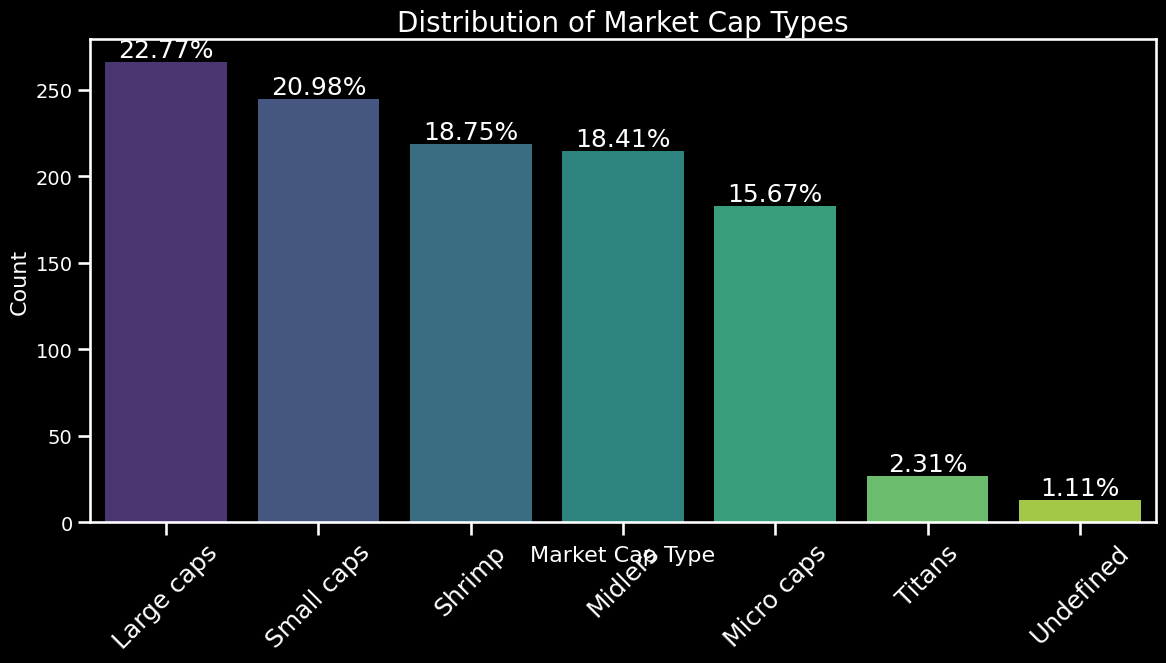

In [163]:
# Set dark mode for plotting
plt.style.use('dark_background')
sns.set_context('talk')  # Larger fonts and figures

# Create a bar chart with a modern and professional look
plt.figure(figsize=(12, 7))
# Assign 'marketCapType' to both x and hue, and explicitly disable the legend
barplot = sns.barplot(data=mc_groups, x='marketCapType', y='count', hue='marketCapType', palette='viridis', legend=False)

# After plotting, you can disable the legend that comes with using 'hue'
plt.legend([],[], frameon=False)

# Customize the plot with percentage labels
for index, row in mc_groups.iterrows():
    # Adjust the positioning based on your data for clarity
    barplot.text(index, row['count'], f'{row["percentage"]:.2f}%', color='white', ha="center", va="bottom")

# Add marketCapType labels underneath the bars
for index, row in mc_groups.iterrows():
    barplot.text(index, -10, row['marketCapType'], color='white', ha="center", va="top", rotation=45)

plt.title('Distribution of Market Cap Types', fontsize=20, color='white')
plt.xlabel('Market Cap Type', fontsize=16, color='white')
plt.ylabel('Count', fontsize=16, color='white')
plt.xticks(rotation=45, fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')

# Remove x-axis labels to avoid redundancy due to hue
barplot.set_xticklabels([])

# Show the plot
plt.tight_layout()
plt.show()

In [160]:
# print length of df
print(len(tv_df.index))
# print sample head
tv_df.sample(10)

1155


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years,marketCapType
122,COR,"Cencora, Inc.",NYSE,4.733109e+10,USD,237.2700,USD,0.3600,USD,0.153584,...,1.565099,1.369454,1.602613,236.610000,25.84105686,Distribution Services,0.38533163,0.8090972,0.44866017,Large caps
634,KC,Kingsoft Cloud Holdings Limited,NASDAQ,7.586520e+08,USD,3.0500,USD,0.1800,USD,6.101695,...,7.432432,6.921366,5.582622,3.060000,-,Technology Services,4.11468,1.9745839,2.115865,Small caps
834,TSE,Trinseo PLC,NYSE,1.534513e+08,USD,4.3600,USD,0.1100,USD,2.540416,...,4.886256,4.708120,8.050783,4.335400,-,Process Industries,2.7933643,1.6581854,1.6114206,Micro caps
313,S,"SentinelOne, Inc.",NYSE,8.129928e+09,USD,27.2200,USD,0.6500,USD,2.466793,...,4.254518,4.204323,4.296256,27.086667,-,Technology Services,1.7378999,0.7038514,0.7038514,Midlers
997,FBRX,"Forte Biosciences, Inc.",NASDAQ,2.507122e+07,USD,0.6900,USD,0.0240,USD,3.630862,...,7.692142,7.121929,11.570006,0.680000,-,Health Technology,0.7307182,1.6277568,0.44165656,Shrimp
678,BLND,"Blend Labs, Inc.",NYSE,5.534836e+08,USD,2.2300,USD,0.0800,USD,3.587444,...,6.912442,13.275216,9.332340,2.240000,-,Technology Services,1.3839312,0.9914206,0.9914206,Small caps
512,HBM,Hudbay Minerals Inc.,NYSE,1.953884e+09,USD,5.6000,USD,0.2600,USD,4.841713,...,10.344828,3.969165,3.070918,5.526667,197.60161045,Non-Energy Minerals,2.1550283,1.9746858,1.9731789,Small caps
275,LAMR,Lamar Advertising Company,NASDAQ,1.150845e+10,USD,110.0800,USD,5.1700,USD,4.582115,...,8.050340,3.972458,2.456059,112.187867,27.23404255,Finance,1.8002135,1.3518103,1.5201854,Large caps
1104,ATXI,"Avenue Therapeutics, Inc.",NASDAQ,5.017572e+06,USD,0.1345,USD,0.0043,USD,3.023910,...,10.681818,7.832078,10.520111,0.137533,-,Health Technology,-0.30205587,-1.6838087,-0.27549174,Shrimp
631,CYRX,"CryoPort, Inc.",NASDAQ,7.746060e+08,USD,15.8200,USD,0.0600,USD,0.376412,...,7.343447,5.082352,4.973475,15.979167,-,Transportation,2.2469604,1.9223473,1.5746933,Small caps


In [159]:
# show unique values for 'marketCapType'
tv_df['marketCapType'].unique()

array(['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps',
       'Shrimp'], dtype=object)

In [161]:
# market cap dataframes
titans_df = tv_df[tv_df['marketCapType'] == 'Titans']
large_caps_df = tv_df[tv_df['marketCapType'] == 'Large caps']
midlers_df = tv_df[tv_df['marketCapType'] == 'Midlers']
small_caps_df = tv_df[tv_df['marketCapType'] == 'Small caps']
micro_caps_df = tv_df[tv_df['marketCapType'] == 'Micro caps']
shrimp_df = tv_df[tv_df['marketCapType'] == 'Shrimp']

In [164]:
print(len(titans_df.index))

midlers_df

27


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,...,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Beta 1 year,Beta 3 years,Beta 5 years,marketCapType
293,MNDY,monday.com Ltd.,NASDAQ,9.924702e+09,USD,207.90,USD,1.39,USD,0.669525,...,2.453271,3.850541,4.201227,207.940000,-,Technology Services,2.092986,1.1817178,1.1817178,Midlers
294,LSXMA,Liberty Media Corporation - Series A Liberty S...,NASDAQ,9.911972e+09,USD,30.35,USD,0.13,USD,0.436681,...,2.109846,1.995715,2.088110,30.203333,15.98293749,Consumer Services,1.2387244,0.96303993,1.1237695,Midlers
295,WPP,WPP plc,NYSE,9.886357e+09,USD,46.17,USD,0.46,USD,1.007667,...,1.525387,1.678152,1.411619,46.136667,74.39574605,Commercial Services,1.061373,1.0631634,1.3487414,Midlers
296,LSXMK,Liberty Media Corporation - Series C Liberty S...,NASDAQ,9.849916e+09,USD,30.16,USD,0.21,USD,0.709699,...,2.089653,2.050970,2.051910,30.013333,15.88287956,Consumer Services,1.3543465,0.97432625,1.142989,Midlers
297,YPF,YPF Sociedad Anonima,NYSE,9.383727e+09,USD,18.04,USD,0.04,USD,0.221607,...,2.959184,4.550185,3.753086,17.947333,7.86090897,Energy Minerals,1.124193,1.4824657,1.8841325,Midlers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,TGH,Textainer Group Holdings Limited,NYSE,2.072514e+09,USD,50.09,USD,0.18,USD,0.360649,...,0.399361,0.150573,0.142107,50.093333,11.56652658,Finance,-0.28431413,1.0803758,1.0129033,Midlers
504,TGH/PB,Textainer Group Holdings Limited Depositary Sh...,NYSE,2.065066e+09,USD,25.12,USD,0.17,USD,0.684105,...,1.198562,0.278505,0.338687,25.100000,5.80058191,Finance,0.16275036,0.5432745,0.5432745,Midlers
505,UTF,"Cohen & Steers Infrastructure Fund, Inc",NYSE,2.027080e+09,USD,21.72,USD,0.07,USD,0.323625,...,1.063338,1.143643,1.562637,21.736667,-,Miscellaneous,1.135555,0.9767629,1.023767,Midlers
506,HIMS,"Hims & Hers Health, Inc.",NYSE,2.018178e+09,USD,9.52,USD,0.05,USD,0.529101,...,2.512026,3.253378,4.166780,9.488333,-,Health Services,1.8837495,1.2226751,0.7648832,Midlers


In [ ]:
# EXAMPLE IDEA for market cap groups
# microcap_df = screener_df_x[screener_df_x['marketcapType'] == 'Micro-Cap']
# smallcap_df = screener_df_x[screener_df_x['marketcapType'] == 'Small-Cap']
# midcap_df = screener_df_x[screener_df_x['marketcapType'] == 'Mid-Cap']
# largecap_df = screener_df_x[screener_df_x['marketcapType'] == 'Large-Cap']
# megacap_df = screener_df_x[screener_df_x['marketcapType'] == 'Mega-Cap']

In [ ]:
# EXAMPLE IDEA for filtering by market cap
#     # Percentage (%) thresholds per market cap type
#     thresholds = {
#         'Titans': '0.005',
#         'Large caps': '0.01',
#         'Midlers': '0.02',
#         'Small caps': '0.03',
#         'Micro caps': '0.04',
#         'Shrimp': '0.05'
#     }

# THEN we need filters using things like float, volatility, volume, etc. to further filter down the stocks

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [ ]:
# def filter_pre_market(df):
#     # Convert 'Pre-market Change %' to numeric, coercing errors to NaN
#     df['Pre-market Change %'] = pd.to_numeric(df['Pre-market Change %'].str.rstrip('%'), errors='coerce') / 100
    
#     # Check if conversion resulted in any non-NaN values
#     if df['Pre-market Change %'].isna().all():
#         print("Warning: 'Pre-market Change %' conversion resulted in all NaN values.")
    
#     # Percentage (%) thresholds per market cap type
#     thresholds = {
#         'Titans': '0.005',
#         'Large caps': '0.01',
#         'Midlers': '0.02',
#         'Small caps': '0.03',
#         'Micro caps': '0.04',
#         'Shrimp': '0.05'
#     }

#     # Use the map to apply thresholds
#     threshold_map = df['marketCapType'].map(thresholds)
    
#     # Directly filter using the mapped thresholds
#     df_filtered = df[df['Pre-market Change %'] >= threshold_map]

#     # Diagnostic message to check if any rows meet the condition
#     if len(df_filtered) == 0:
#         print("No rows meet the threshold conditions.")
    
#     return df_filtered

# # Assuming tv_df is your initial DataFrame and it's already been categorized by market cap type
# print(f'Length before filtering: {len(tv_df.index)}')
# tv_df_filtered = filter_pre_market(tv_df)
# print(f'Length after filtering: {len(tv_df_filtered.index)}')


In [ ]:
# def filter_pre_market(df):
#     # Ensure 'Pre-market Change %' is numeric, coercing errors to NaN
#     df['Pre-market Change %'] = pd.to_numeric(df['Pre-market Change %'].str.rstrip('%'), errors='coerce') / 100

#     # Percentage (%) thresholds per market cap type
#     thresholds = {
#         'Titans': 0.005,
#         'Large caps': 0.01,
#         'Midlers': 0.02,
#         'Small caps': 0.03,
#         'Micro caps': 0.04,
#         'Shrimp': 0.05
#     }

#     # Instead of iterating and filtering, use the map to apply thresholds and directly filter
#     threshold_map = df['marketCapType'].map(thresholds)
#     df_filtered = df[df['Pre-market Change %'] >= threshold_map]

#     return df_filtered

# # Assuming tv_df is your initial DataFrame and it's already been categorized by market cap type
# print(f'Length before filtering: {len(tv_df.index)}')
# tv_df = filter_pre_market(tv_df)
# print(f'Length after filtering: {len(tv_df.index)}')


,marketCapType,count
0,Large caps,266
1,Small caps,245
2,Shrimp,219
3,Midlers,215
4,Micro caps,183
5,Titans,27


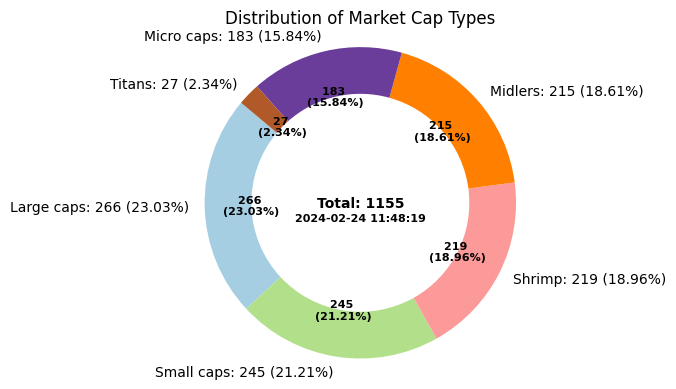

In [74]:
# from IPython.display import display, HTML
# import matplotlib.pyplot as plt
# from datetime import datetime
# import numpy as np

# # Assuming mc_groups is your DataFrame
# # Convert DataFrame to HTML and add custom styling for clearer, larger display
# html = mc_groups.to_html(classes='table table-striped')
# style = """
# <style>
#     .table {float: left; margin-right: 20px;}
#     .table th, .table td {font-size: 18px;}
# </style>
# """
# display(HTML(style + html))

# # Now, plot the donut chart, scaled down a bit, next to the DataFrame
# fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size to scale down the chart

# # Pie chart code here, modified to fit the new figure size
# # Assume your labels, sizes, percentages, and colors are defined as before

# wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, startangle=140,
#                                   autopct='', pctdistance=0.85, wedgeprops=dict(width=0.3))

# # Customizing texts inside the donut as before
# for i, p in enumerate(wedges):
#     angle = (p.theta2 - p.theta1) / 2. + p.theta1
#     y = np.sin(np.deg2rad(angle))
#     x = np.cos(np.deg2rad(angle))
#     percentage = f'{sizes[i]} \n({percentages[i]:.2f}%)'
#     ax.text(x*0.7, y*0.7, percentage, ha='center', va='center', fontsize=8, color='black', weight='bold')

# ax.set_title('Distribution of Market Cap Types', fontsize=12)
# ax.text(0, 0, f'Total: {sizes.sum()}', ha='center', va='center', fontsize=10, color='black', weight='bold')
# ax.text(0, -0.1, datetime.now().strftime('%Y-%m-%d %H:%M:%S'), ha='center', va='center', fontsize=8, color='black', weight='bold')

# plt.axis('equal')
# plt.tight_layout()
# plt.show()


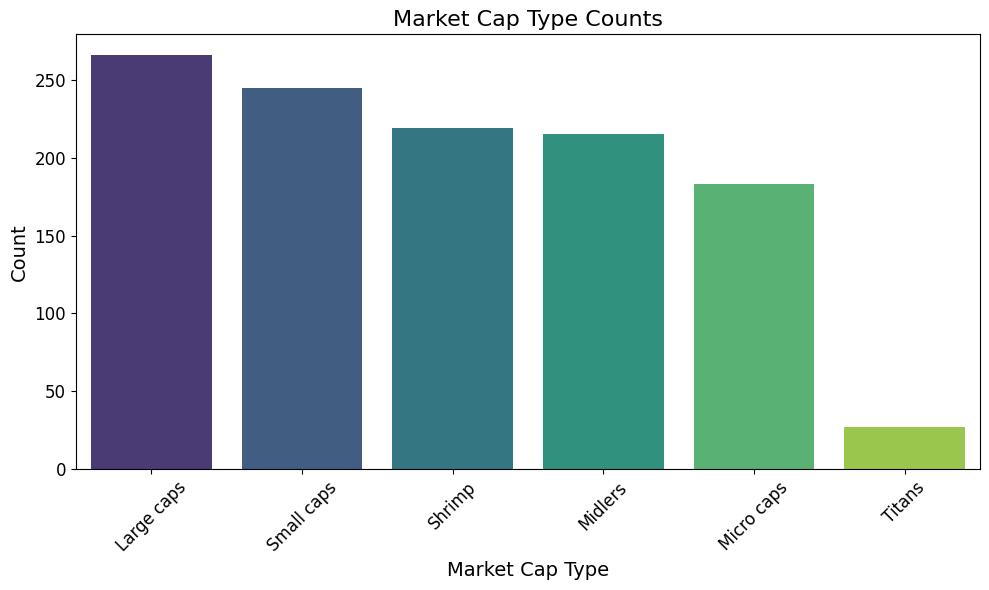

In [62]:
# plt.figure(figsize=(10, 6))
# # Assign 'marketCapType' to both x and hue, and disable the legend.
# sns.barplot(data=mc_groups, x='marketCapType', y='count', hue='marketCapType', palette='viridis', legend=False)
# plt.title('Market Cap Type Counts', fontsize=16)
# plt.xlabel('Market Cap Type', fontsize=14)
# plt.ylabel('Count', fontsize=14)
# plt.xticks(rotation=45, fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()

# # Since we're now using 'hue', you'll need to remove the legend explicitly if it still appears.
# plt.legend([],[], frameon=False)

# plt.show()

In [ ]:
# feature selection
# features = ['Market capitalization', 'Volume 1 day', 'Volatility 1 week', 'Beta 1 year', 'Sector']
# features = features_raw_all
# target = 'Post-market Change %'

# # Preprocessing data: Drop rows with missing values in the selected columns
# tv_clean_df = trading_view_raw_df[features + [target]].dropna()

# # Check the unique values and their frequency for the target variable
# print(tv_clean_df['Post-market Change %'].value_counts())


# # Encoding categorical variables and scaling numerical variables
# categorical_features = ['Sector']
# numeric_features = list(set(features) - set(categorical_features))

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ])

# # Prepare the data for modeling
# X = tv_clean_df[features]
# y = tv_clean_df[target]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define and fit the model
# model = Pipeline(steps=[('preprocessor', preprocessor),
#                         ('regressor', LinearRegression())])

# model.fit(X_train, y_train)

# # Predict and evaluate the model
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'MSE: {mse}')
# print(f'R^2: {r2}')

# # For detailed statistics, we need to fit the model using statsmodels
# # We'll prepare the data again because statsmodels requires it to be done differently
# X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
# X_train_transformed = sm.add_constant(X_train_transformed)  # Adding a constant for the intercept

# # Fit the model using OLS
# ols_model = sm.OLS(y_train, X_train_transformed).fit()

# # Print the summary of the model to see detailed statistics
# print(ols_model.summary())
